# TOUGOU 

Quantify the aquifer recharge below an intermitent river.

Parameters of the model
- the intrinsic permeability $k$ (m<sup>2</sup>)
- the porosity $n$
- the alpha Van Genuchten parameter $\alpha$,
- the $n$ Van Genuchten parameter, 
- the residual saturation $s_{wres}$
The heterogenieties are prescribed thanks E_zone_parameter.dat


Boundaty conditions fluctuate with the time:
- the file data_hydro_P95-B52.txt contains the value of the hydraulic head to the bottom and the top. Adapt the section 1.2 to this notebook to your file of data.
-Diriclet or Neuman : E_cl_icl.dat
-value : E_cl_val.dat
reading time = itlecture



# 1 Fill parameters and setup

In [1]:
import os
import numpy as np
from pathlib import Path
import pandas as pd
import array
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import warnings
import math
import sys
import shutil  
import os    
import subprocess
from importlib import reload
# path of the 1D_col directory
os.chdir('/home/ariviere/Programmes/ginette/application/Tougou/')

from setup_model import *

import setup_model
reload(setup_model)


libs_gfortran = ['gfortran']
# please compile ginette in the folder 1D_col








/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1.1 Parametres

In [2]:
#-----------------------------------------------------------------
########### Setup of the model
#_________________________________________________________________
#time step in 
dt=900
# time reading of the BC in seconds
itlecture=600
#duration of the simulation in days
nb_day=12
# state
## 0 steady state
# 1 transient state (dynamic state)
state=1

# altitude of the column top in meter
z_top=169.4

#altitude column bottom in meter
z_bottom=169.4-15

#discretisation : size cell in meter
dz=0.1

#apply unsaturated flow and thermal 
#unsat =1 apply
#unsat=0 cancel unsaturated zone
unsat=1
#_________________________________________________________________

######### PARAMETERS 
#-----------------------------------------------------------------
# number of facies in the column. If nb_zone=1 homognous porous media
nb_zone=2
# constant parameters
## val_k intrinsic permeability [m2]  
## K hydraulic conductivity [m.s-1] k=val_k*mu/(rho*g)
## mu viscosity [Pa.s]
## rho density [kg.m-3]
## g gravity  9.81 [m2.s-1]
# porosity [-]
# nVG van genuchten parameter [-]
# a van genuchten parameter [-]
# swres residual saturation [-]


# Exemple de valeurs pour 2 zones
val_k_list = [1e-14, 1e-13]  # Valeurs de k pour chaque zone
val_n_list = [0.35, 0.2]  # Valeurs de n pour chaque zone
val_a_list = [2, 2]  # Valeurs de a pour chaque zone
val_nVG_list = [2, 2.4]  # Valeurs de nVG pour chaque zone
val_swres_list = [0.05, 0.1]  # Valeurs de swres pour chaque zone
geom_zone_list=[0.5,z_bottom]  # Valeurs de geom pour chaque zone




## 1.2 files of boundary conditions

time between observations 600 s
time between observations is constant
max time 12.0


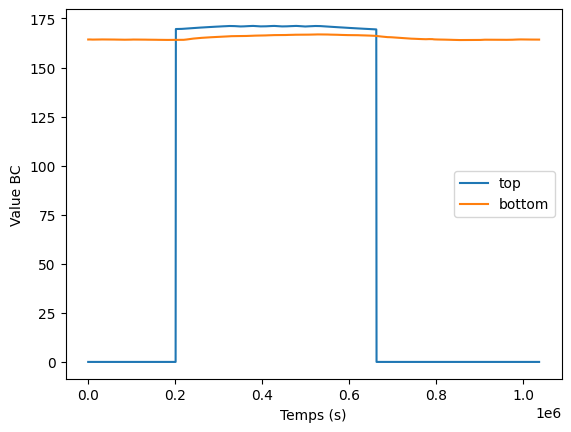

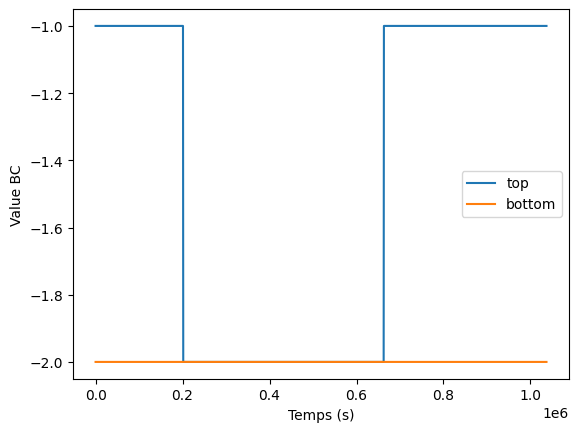

In [17]:
# Boundary condition water level (meter)
#-----------------------------------------------------------------
## z=0 : dirichlet condition when hydraulic head is above z_top and neuman condition when hydraulic head is below z_top
### create boundary condition  hydraulic head increase with sin function in 4 days and decrease in 4 days amplitude 2m
### hydraulic head at the top of the column h_top(t)
### create funtion h_top(t) with a sin function in dataframe



#read data
data_BC=pd.read_csv('data_hydro_P95-B52.txt')

# write E_ec_bc_t.dat with column 1 B52(m) and column 2 P95(m.a.s.l)
data_BC['bottom']=data_BC['P95(m.a.s.l)']
data_BC['top']=data_BC['B52(m)']+z_top


val_WT=data_BC['P95(m.a.s.l)'][0]
#calculate the time between observations
time_measure=data_BC['minutes'][1]-data_BC['minutes'][0]
print('time between observations',time_measure*60,'s')
#Check the time measure is constant for all data_BC
if all(data_BC['minutes'].diff()[1:]-time_measure==0):
    print('time between observations is constant')
 
 
# generate values and definition of the boundary condition
# integer in E_cl_val.dat
data_BC['icltop']=-2
data_BC['iclbottom']=-2
data_BC.loc[data_BC['top']<=z_top, 'icltop'] = -1
data_BC.loc[data_BC['top']>z_top, 'icltop'] = -2
data_BC.loc[data_BC['top']<=z_top, 'top'] = 1e-8



data=data_BC[['top','bottom']]
icl=data_BC[['icltop','iclbottom']]  
data.to_csv('E_cl_val.dat', sep=' ', index=False, header=False)
# integer in icl file
icl.to_csv('E_cl_icl.dat', sep=' ', index=False, header=False)
    
# time step reading the boundary condition in seconds
itlecture=int(time_measure*60)
max_time=data_BC['minutes'].max()*60/86400
print('max time',max_time)
nb_day=max_time

plt.plot(data_BC['minutes']*60, data_BC['top'])
plt.plot(data_BC['minutes']*60, data_BC['bottom'])
plt.xlabel('Temps (s)')
plt.ylabel('Value BC')
plt.legend(['top', 'bottom'])
plt.show()


# Tracé avec une courbe plus arrondie
plt.plot(data_BC['minutes']*60, data_BC['icltop'])
plt.plot(data_BC['minutes']*60, data_BC['iclbottom'])
plt.xlabel('Temps (s)')
plt.ylabel('Value BC')
plt.legend(['top', 'bottom'])
plt.show()


## 1.3 fill Input file of Ginette

In [25]:
nb_cell=domain_state_time(z_top,z_bottom,dz,dt,state,nb_day,unsat)
print('number of cells',nb_cell)
coord=geometry(z_top,z_bottom,dz,nb_zone)
initial_boundary_condition(val_WT,itlecture)
parameter_zone_geometrie(nb_zone,geom_zone_list,dz,z_top,z_bottom)
# delete the file E_parametre_zone.dat
if os.path.isfile('E_zone_parameter.dat'):
    os.remove('E_zone_parameter.dat')
for i in range(nb_zone):
    parameter_zone_value(i+1, val_k_list[i], val_n_list[i], val_a_list[i], val_nVG_list[i],val_swres_list[i])

number of cells 150.0


## 1.4 compile Ginette

In [26]:

#-----------------------------------------------------------------
# Compile ginette
if os.path.isfile('ginette'):
    print ("ginette exist")
else:
    print ("ginette not exist")
    print("you must compile ginette in the current directory")
    print(" gfortran -o ginette ../../src/ginette_V2.f")
    subprocess.call(["gfortran","-o","ginette","../../src/ginette_V2.f"])  #creat






ginette exist


## 2. Run the simulation

In [27]:
# run ginette
subprocess.call(["./ginette"])

 time   900.00000000000000      dt   900.00000000000000        164.28409588574820        169.35000000000102        1.0000000000000000        1.0000000000000000E-014
 time   1800.0000000000000      dt   900.00000000000000        164.29811526723975        169.35000000000102        1.0000000000000000        1.0000000000000000E-014
 time   2700.0000000000000      dt   900.00000000000000        164.31205792708687        169.35000000000102        1.0000000000000000        1.0000000000000000E-014
 time   3600.0000000000000      dt   900.00000000000000        164.32592491248607        169.35000000000102        1.0000000000000000        1.0000000000000000E-014
 time   4500.0000000000000      dt   900.00000000000000        164.33971683931628        169.35000000000102        1.0000000000000000        1.0000000000000000E-014
 time   5400.0000000000000      dt   900.00000000000000        164.35343431681156        169.35000000000102        1.0000000000000000        1.0000000000000000E-014
 time   63

0

# Profile saturation référence au bo

In [29]:
# read the saturation profil   
saturation_profile_REF = pd.read_table('S_saturation_profil_t.dat',delim_whitespace=True,header=None,names=[ "time",  "z","sat"])
saturation_profile_val=saturation_profile_REF.iloc[saturation_profile_REF.index.stop-int(nb_cell):saturation_profile_REF.index.stop]
saturation_profile_val.head()

,time,z,sat
172650,1036800.0,169.35,1.000000
172651,1036800.0,169.25,1.000000
172652,1036800.0,169.15,0.258398
172653,1036800.0,169.05,0.149143
172654,1036800.0,168.95,0.150922


TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

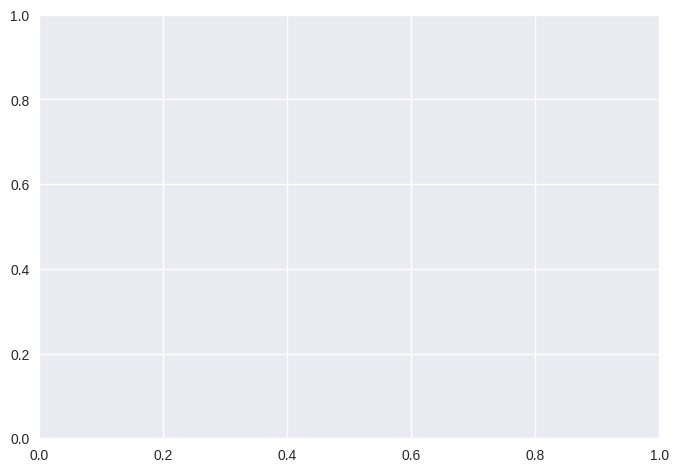

In [24]:
# interpolation of sat in function of z and time

fig, ax = plt.subplots()
saturation_profile_val.pivot("time", "z", "sat").plot(ax=ax)
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Saturation profile')
plt.show()

/tmp/ipykernel_160039/2987567205.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


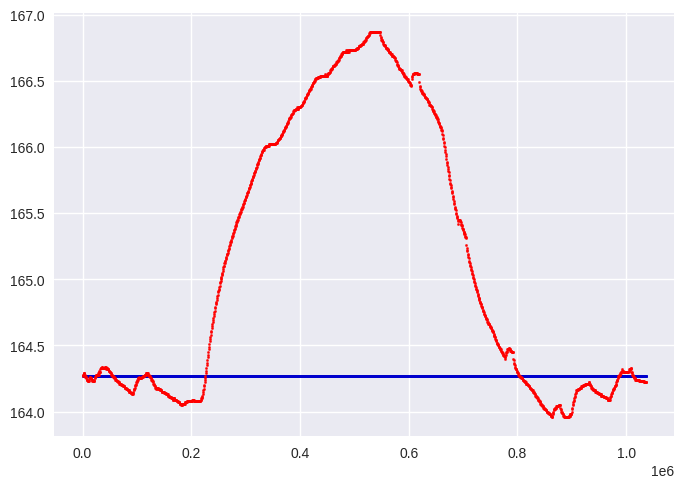

In [23]:
h_profile_REF = pd.read_table('S_pressure_profil_t.dat',delim_whitespace=True,header=None,names=[ "time",  "z","pressure","h"])
#hydraulic head for the min z 

min_z=z_top-1
# find nearest value to min_z

h_profile_val=h_profile_REF[(h_profile_REF['z']<=min_z+dz)&(h_profile_REF['z']>=min_z-dz)]
plt.figure()
plt.style.use('seaborn')
plt.scatter(h_profile_val.time,h_profile_val.h, s=10, alpha=1, color='mediumblue',marker='.')
plt.scatter(data_BC['minutes']*60, data_BC['P95(m.a.s.l)'], s=10, alpha=1, color='red',marker='.')